# Agregación y Agrupación
Una parte fundamental de muchas tareas de análisis de datos es la resumisión eficiente: calcular agregaciones como suma, media, mediana, mínimo y máximo, en las que un solo número resume aspectos de un conjunto de datos potencialmente grande. En este capítulo, exploraremos las agregaciones en Pandas, desde operaciones simples similares a las que hemos visto en arreglos de NumPy hasta operaciones más sofisticadas basadas en el concepto de groupby.

Para conveniencia, utilizaremos la misma función mágica de visualización que usamos en los capítulos anteriores:

In [2]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

# Datos de Planetas
Aquí utilizaremos el conjunto de datos de Planetas, disponible a través del paquete Seaborn (ver Visualización con Seaborn). Este conjunto de datos proporciona información sobre los planetas que los astrónomos han descubierto alrededor de otras estrellas (conocidos como planetas extrasolares, o exoplanetas, para abreviar). Se puede descargar con un simple comando de Seaborn:

In [5]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [7]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


# Agregación Simple en Pandas
En "Agregaciones: Mínimo, Máximo y Todo lo que Hay Entre Ellos", exploramos algunas de las agregaciones de datos disponibles para arreglos de NumPy. Al igual que con un arreglo unidimensional de NumPy, para una Serie de Pandas, las agregaciones devuelven un solo valor:

In [10]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [12]:
ser.sum()

2.811925491708157

In [14]:
ser.mean()


0.5623850983416314

In [16]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [18]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

In [20]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64



**Las Series y los objetos DataFrame de Pandas incluyen todas las agregaciones comunes mencionadas en Agregaciones: Mínimo, Máximo y Todo lo que Hay Entre Ellos; además, hay un método de conveniencia, describe, que calcula varias agregaciones comunes para cada columna y devuelve el resultado. Utilicemos esto en los datos de Planetas, descartando por ahora las filas con valores faltantes:**

In [24]:

planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000




**Este método nos ayuda a entender las propiedades generales de un conjunto de datos. Por ejemplo, vemos en la columna de año que, aunque los exoplanetas fueron descubiertos desde 1989, la mitad de todos los planetas en el conjunto de datos no fueron descubiertos hasta 2010 o después. Esto se debe en gran parte a la misión Kepler, que tenía como objetivo encontrar planetas en tránsito alrededor de otras estrellas utilizando un telescopio espacial diseñado especialmente.**

**La siguiente tabla resume algunas otras agregaciones incorporadas en Panda

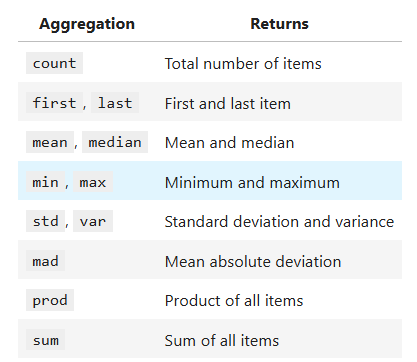s:**



**Estos son todos métodos de los objetos DataFrame y Series.**

**Sin embargo, para profundizar en los datos, las agregaciones simples a menudo no son suficientes. El siguiente nivel de resumisión de datos es la operación groupby, que te permite calcular agregados de manera rápida y eficiente en subconjuntos de datos.**

**groupby: Dividir, Aplicar, Combinar**  
Las agregaciones simples pueden darte una idea de tu conjunto de datos, pero a menudo preferiríamos agregar condicionalmente en alguna etiqueta o índice: esto se implementa en la llamada operación groupby. El nombre "group by" proviene de un comando en el lenguaje de base de datos SQL, pero quizás sea más ilustrativo pensar en él en los términos que acuñó por primera vez Hadley Wickham, famoso en Rstats: dividir, aplicar, combinar.

**Dividir, Aplicar, Combinar**  
Un ejemplo canónico de esta operación de dividir-aplicar-combinar, donde "aplicar" es una agregación de suma, se ilustra en esta figura:

*(fuente de la figura en el Apéndice)*

Esto ilustra lo que logra la operación groupby:

1. El paso de dividir implica descomponer y agrupar un DataFrame según el valor de la clave especificada.
2. El paso de aplicar implica calcular alguna función, generalmente una agregación, transformación o filtrado, dentro de los grupos individuales.
3. El paso de combinar fusiona los resultados de estas operaciones en un array de salida.

Si bien esto podría hacerse manualmente utilizando alguna combinación de los comandos de enmascaramiento, agregación y fusión cubiertos anteriormente, una realización importante es que las divisiones intermedias no necesitan ser instanciadas explícitamente. Más bien, el groupby puede (a menudo) hacer esto en una sola pasada sobre los datos, actualizando la suma, media, conteo, mínimo u otra agregación para cada grupo en el camino. El poder del groupby es que abstrae estos pasos: el usuario no necesita pensar en cómo se realiza el cálculo en el fondo, sino que puede pensar en la operación en su totalidad.

Como ejemplo concreto, echemos un vistazo a cómo usar Pandas para el cálculo mostrado en la siguiente figura. Comenzaremos creando el DataFrame de entrada:

In [32]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


La operación más básica de dividir-aplicar-combinar se puede calcular con el método groupby del DataFrame, pasando el nombre de la columna clave deseada:

In [35]:
df.groupby('key')

In [37]:

planets.groupby('method')

In [39]:
planets.groupby('method')['orbital_period']

In [41]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

## 
Iteration over groups

In [44]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


In [46]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.0
       Eclipse Timing Variations           9.0
       Imaging                            38.0
       Microlensing                       23.0
       Orbital Brightness Modulation       3.0
                                         ...  
max    Pulsar Timing                    2011.0
       Pulsation Timing Variations      2007.0
       Radial Velocity                  2014.0
       Transit                          2014.0
       Transit Timing Variations        2014.0
Length: 80, dtype: float64

In [48]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


## Aggregation

In [51]:

df.groupby('key').aggregate(['min', np.median, max])

C:\Users\andyl\AppData\Local\Temp\ipykernel_9900\3831777116.py:1: FutureWarning: The provided callable <function median at 0x000001E27A355620> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby('key').aggregate(['min', np.median, max])
C:\Users\andyl\AppData\Local\Temp\ipykernel_9900\3831777116.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df.groupby('key').aggregate(['min', np.median, max])


data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

In [53]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


In [55]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()",
        "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

In [57]:
def center(x):
    return x - x.mean()
df.groupby('key').transform(center)

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


## Metodo Aplicado

In [60]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

df.groupby('key').apply(norm_by_data2)

C:\Users\andyl\AppData\Local\Temp\ipykernel_9900\2266638224.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('key').apply(norm_by_data2)


key     data1  data2
key                       
A   0   A  0.000000      5
    3   A  0.375000      3
B   1   B  0.142857      0
    4   B  0.571429      7
C   2   C  0.166667      3
    5   C  0.416667      9

In [62]:
L = [0, 1, 0, 1, 2, 0]
df.groupby(L).sum()

,key,data1,data2
0,ACC,7,17
1,BA,4,3
2,B,4,7


In [64]:
df.groupby(df['key']).sum()

,data1,data2
key,,
A,3,8
B,5,7
C,7,12


In [66]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
key,,
consonant,12,19


In [68]:

df2.groupby(str.lower).mean()

,data1,data2
key,,
a,1.5,4.0
b,2.5,3.5
c,3.5,6.0


In [70]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
key,key,,
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


In [72]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0




**Esto muestra el poder de combinar muchas de las operaciones que hemos discutido hasta este punto al observar conjuntos de datos realistas: rápidamente obtenemos una comprensión general de cuándo y cómo se detectaron los planetas extrasolares en los años posteriores al primer descubrimiento.**

**Sugeriría que indagues en estas pocas líneas de código y evalúes los pasos individuales para asegurarte de que comprendes exactamente lo que están haciendo con el resultado. Sin duda, es un ejemplo algo complicado, pero comprender estas partes te dará las herramientas para explorar tus propios datos de manera similar.**